In [1]:
from scGeneFit.functions import *

%matplotlib inline
import numpy as np
np.random.seed(0) 

In [2]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

# ML

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time


from sklearn.impute import SimpleImputer

#tcga = pd.read_csv('../../../data/My_own_project/TCGA_ready_monod2_intersectedSortedMerged_std_filtered_cpg5_std0.1_sorted_Allmatrix',sep='\t')
tcga = pd.read_csv('../../../data/My_own_project/TCGA_ready_monod2_intersectedSortedMerged_std_filtered_cpg5_std0.1_sorted_Allmatrix_TOF',sep='\t')
onevsall_NUM_MARKERS = 20
Replicate_Threshold =  150
Exclude_Targets = ['Kidney_TCGA-KIRP_Primary_Tumor','Kidney_TCGA-KIRC_Solid_Tissue_Normal','Bronchus_and_lung_TCGA-LUSC_Primary_Tumor']
print(tcga.shape)
tcga.head()

(2744, 2165)


,feature,Prostate_gland_TCGA-PRAD_Primary_Tumor_cd70ed89-aad8-4e29-a71f-290a823471cf.methylation_array.sesame.level3betas.txt_WGBS,GuNormal_Normal_0f48d8af-223f-4c00-9b13-540614d35bbc.methylation_array.sesame.level3betas.txt_WGBS,Bladder_TCGA-BLCA_Primary_Tumor_06a77641-690f-4839-8ba0-e20f3d6fcc63.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_2128c5a6-3f5c-42d4-8977-c0136c19ee35.methylation_array.sesame.level3betas.txt_WGBS,Testis_TCGA-TGCT_Primary_Tumor_8774b347-ca52-4e77-aa8e-8f4c5a3a5881.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_2ec63f4b-14f7-45ee-89f7-1566e1119f9a.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_b80c7716-9c46-414f-befe-36bb3a6c2d10.methylation_array.sesame.level3betas.txt_WGBS,Bladder_TCGA-BLCA_Primary_Tumor_145eebc7-a40e-47ee-b0f8-3e917e2bc8ec.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_18fd65eb-c745-4280-b7e1-5d599c18caa2.methylation_array.sesame.level3betas.txt_WGBS,...,Bladder_TCGA-BLCA_Primary_Tumor_954cc1a5-a6ad-4304-9056-e389245bdff5.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_9f904996-9b19-4c80-a19e-03131a9eaf33.methylation_array.sesame.level3betas.txt_WGBS,Bladder_TCGA-BLCA_Primary_Tumor_a862b7d6-bfef-47ee-8178-2c0bf172ff62.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_b12ce33a-047f-4a5c-aec1-68f819d5d9cd.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_ed57f8af-9edb-4a17-b3ad-08b2523f5f32.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_57d94608-2d6a-4d9f-9c97-ca657236e47c.methylation_array.sesame.level3betas.txt_WGBS,GuNormal_Normal_cbb356d9-cd57-44d7-9e00-cb909f19deee.methylation_array.sesame.level3betas.txt_WGBS,Kidney_Tumor_a8f732f2-d7de-497e-863a-ffb4889f8493.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_89e511de-7e33-413d-9e53-ebb8022f86e5.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_73298c7a-eff4-419f-a6f0-db31e208bf86.methylation_array.sesame.level3betas.txt_WGBS
0,chr10:100186139-100186254,0.038079,0.033680,0.045673,0.041220,0.037142,0.049250,0.036399,0.049927,0.041981,...,0.034704,0.043166,0.055467,0.043710,0.046069,0.034452,0.039189,0.033549,0.038890,0.058949
1,chr10:100229578-100229629,0.018440,0.018486,0.021058,0.016040,0.022861,0.020706,0.018584,0.023005,0.019828,...,0.019458,0.022827,0.020899,0.022067,0.019800,0.023625,0.023982,0.022662,0.018656,0.025678
2,chr10:100267670-100267870,0.029624,0.025504,0.029622,0.025770,0.028268,0.055277,0.021815,0.044603,0.033457,...,0.034986,0.030160,0.028496,0.030038,0.033509,0.030710,0.043069,0.028764,0.024887,0.037718
3,chr10:100286668-100286790,0.036294,0.029189,0.037887,0.032175,0.040742,0.037519,0.034720,0.045921,0.036324,...,0.025877,0.028892,0.037218,0.038228,0.036275,0.032815,0.030245,0.029463,0.038941,0.036926
4,chr10:100987280-100987660,0.022886,0.019916,0.024324,0.019115,0.023012,0.027638,0.018391,0.029883,0.024673,...,0.019804,0.019216,0.025903,0.023127,0.022794,0.024468,0.021749,0.019789,0.021876,0.027543


In [4]:
#### IMPUTATION should be seperately done
def train_test(input_df, threshold, exclude_targets=None, handle_nan='mean'):
    # Transpose the DataFrame
    df_transposed = input_df.T
    # Remove the first row
    df_transposed = df_transposed.drop(df_transposed.index[0])
    
    # Handle NaN values according to the specified strategy
    if handle_nan == 'mean':
        imputer = SimpleImputer(strategy='mean')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'median':
        imputer = SimpleImputer(strategy='median')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'constant':
        imputer = SimpleImputer(strategy='constant', fill_value=-1)
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'remove':
        df_transposed.dropna(inplace=True)
    
    # List of substrings to search for
    substrings = ['_Tumor', 'Metastatic', '_Normal', '_Cancer']
    
    # Function to create a target value based on the index, by cutting off everything after the specified substrings
    def create_target(index):
        for substring in substrings:
            pos = index.find(substring)
            if pos != -1:
                # Cut off everything after the substring, but include the substring itself
                return index[:pos + len(substring)]
        # If no substring is found, return the index as is
        return index
    
    # Apply the function to each index to create the Target column
    df_transposed['Target'] = [create_target(index) for index in df_transposed.index]
    
    # Encode the 'Target' column, starting with 1
    df_transposed['Target_encoded'] = pd.factorize(df_transposed['Target'])[0] + 1
    
    # Calculate the frequency of each value in the 'Target' column
    value_counts = df_transposed['Target'].value_counts()
    
    # Determine which values meet or exceed the threshold
    values_to_keep = value_counts[value_counts >= threshold].index
    
    # Filter the DataFrame to only include rows with 'Target' values meeting/exceeding the threshold
    df_filtered = df_transposed[df_transposed['Target'].isin(values_to_keep)]
    
    # If exclude_targets is provided, remove rows with 'Target' values in exclude_targets
    if exclude_targets is not None:
        df_filtered = df_filtered[~df_filtered['Target'].isin(exclude_targets)]
    
    # Print information about the target values that pass the threshold
    print("Target values that pass the threshold:", values_to_keep.tolist())
    print("Total number of unique target values that pass the threshold:", len(values_to_keep))
    
    # Print the number of unique targets after excluding specific targets (if any)
    unique_targets_after_exclusion = df_filtered['Target'].nunique()
    print("Number of unique targets after exclusion:", unique_targets_after_exclusion)


    print(df_filtered.shape)


    X_train, X_test, y_train, y_test = train_test_split(
            df_filtered.drop(columns=['Target']), # Features (all columns except 'Target')
            df_filtered['Target'],                # Target variable
            test_size=0.2,                        # Size of the testing set, e.g., 20%
            random_state=0,                      # Seed for random number generator for reproducibility
            stratify=df_filtered['Target']        # Stratify based on the 'Target' column
        )
    return X_train, X_test, y_train, y_test, unique_targets_after_exclusion


# first run train_test
def data_for_scgenefit (df_filtered, df_target):
    # Separate the DataFrame into features, Target_encoded, and Target
    features = df_filtered.drop(['Target_encoded'], axis=1).to_numpy()
    target_encoded = df_filtered['Target_encoded'].to_numpy()
    target = df_target.tolist()
    
    # Return the features as a NumPy array, Target_encoded as a NumPy array, and Target as a list
    return features, target_encoded, target




In [5]:
X_train, X_test, y_train, y_test, number_of_target = train_test( tcga, Replicate_Threshold, exclude_targets = Exclude_Targets)
#X_train, X_test, y_train, y_test, number_of_target = train_test( tcga, 10, exclude_targets = Exclude_Targets)
NUM_MARKERS = number_of_target*onevsall_NUM_MARKERS 
print(tcga.shape)
print(X_train.shape)
print(X_test.shape)

Target values that pass the threshold: ['Kidney_Tumor', 'Prostate_gland_TCGA-PRAD_Primary_Tumor', 'Bladder_TCGA-BLCA_Primary_Tumor', 'GuNormal_Normal', 'Testis_TCGA-TGCT_Primary_Tumor']
Total number of unique target values that pass the threshold: 5
Number of unique targets after exclusion: 5
(2160, 2746)
(2744, 2165)
(1728, 2745)
(432, 2745)


In [6]:
def run_scgenefit(numpy_data,numpy_data_target, num_markers = NUM_MARKERS):
    [data, labels, names] = data_for_scgenefit(numpy_data,numpy_data_target)

    N,d=data.shape
    
    method='centers'
    redundancy=0.25

    start_time = time.time() # Record the start time
    markers= get_markers(data, labels, num_markers, method=method, redundancy=redundancy)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")
    
    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers], labels, data[:,markers], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

    #TSNE plot
    a=plot_marker_selection(data, markers, names)

    return markers

In [7]:
def run_oneVSall (numpy_data,numpy_data_target, num_markers = onevsall_NUM_MARKERS ):
    [data, labels, names] = data_for_scgenefit(numpy_data, numpy_data_target)

    N,d=data.shape

    start_time = time.time() # Record the start time
    #markers2=one_vs_all_selection(data,labels)
    markers2=one_vs_all_selection_per_class(data,labels,num_markers=num_markers)
    #print(type(markers2))
    #print(markers2)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")

    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers2], labels, data[:,markers2], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
    a=plot_marker_selection(data, markers2, names)
    return markers2

In [8]:
y_train_modified = y_train.str.split('_').str[0]


Solving a linear program with 2744 variables and 6 constraints
Time elapsed: 0.42423510551452637 seconds
Execution time: 0.42525601387023926 seconds
Accuracy (whole data, 2744  markers):  0.8530092592592593
Accuracy (selected 100 markers) 0.8414351851851852
Computing TSNE embedding
Elapsed time: 8.170562982559204 seconds


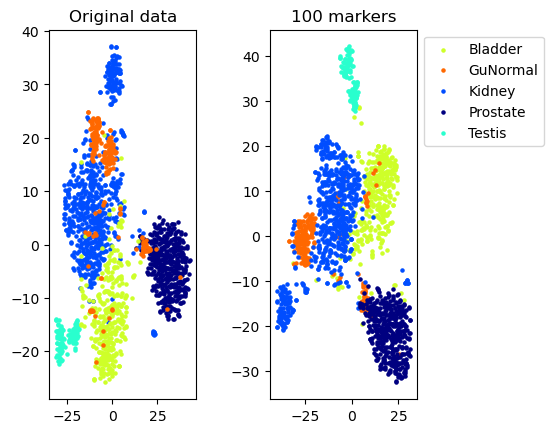

In [9]:
#scMarkers = run_scgenefit(X_train,y_train)
scMarkers = run_scgenefit(X_train,y_train_modified)

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2735,2736,2737,2738,2739,2740,2741,2742,2743,Target_encoded
Kidney_Tumor_79be9fd6-3e8f-404d-83a1-3d4289007a9e.methylation_array.sesame.level3betas.txt_WGBS,0.041398,0.022321,0.034114,0.026419,0.020082,0.020723,0.032999,0.037339,0.019733,0.023154,...,0.039203,0.047954,0.054096,0.063406,0.033352,0.053122,0.098124,0.065411,0.037977,4
Bladder_TCGA-BLCA_Primary_Tumor_4a810b58-b232-4f41-a768-6572b5e922d7.methylation_array.sesame.level3betas.txt_WGBS,0.033764,0.022424,0.024877,0.03004,0.021028,0.015158,0.031466,0.040935,0.016718,0.024245,...,0.040762,0.050192,0.056953,0.040163,0.030338,0.062638,0.068972,0.065411,0.042769,3
Kidney_Tumor_b2051e3a-eaa0-4fc3-936f-5ed5a9572ea2.methylation_array.sesame.level3betas.txt_WGBS,0.033403,0.0362,0.033911,0.029575,0.020697,0.016845,0.027595,0.029689,0.019049,0.021353,...,0.031493,0.042337,0.04099,0.05267,0.033583,0.041448,0.091488,0.065411,0.029608,4
Kidney_Tumor_37ae1055-91aa-4fbe-98ca-17312446bb2b.methylation_array.sesame.level3betas.txt_WGBS,0.048011,0.023716,0.036234,0.038815,0.02586,0.020146,0.03508,0.049515,0.023233,0.024823,...,0.043053,0.048937,0.062335,0.057973,0.029341,0.066259,0.071302,0.065411,0.04519,4
Prostate_gland_TCGA-PRAD_Primary_Tumor_6bb75e65-8f45-4e07-a2e2-282987b608ad.methylation_array.sesame.level3betas.txt_WGBS,0.045051,0.022253,0.031812,0.035832,0.024413,0.020334,0.038325,0.042437,0.020096,0.026303,...,0.039754,0.067428,0.104712,0.04617,0.043732,0.052287,0.059597,0.067473,0.040587,1


In [11]:
display(y_train.head())
display(y_train_modified.head())

Kidney_Tumor_79be9fd6-3e8f-404d-83a1-3d4289007a9e.methylation_array.sesame.level3betas.txt_WGBS                                                        Kidney_Tumor
Bladder_TCGA-BLCA_Primary_Tumor_4a810b58-b232-4f41-a768-6572b5e922d7.methylation_array.sesame.level3betas.txt_WGBS                  Bladder_TCGA-BLCA_Primary_Tumor
Kidney_Tumor_b2051e3a-eaa0-4fc3-936f-5ed5a9572ea2.methylation_array.sesame.level3betas.txt_WGBS                                                        Kidney_Tumor
Kidney_Tumor_37ae1055-91aa-4fbe-98ca-17312446bb2b.methylation_array.sesame.level3betas.txt_WGBS                                                        Kidney_Tumor
Prostate_gland_TCGA-PRAD_Primary_Tumor_6bb75e65-8f45-4e07-a2e2-282987b608ad.methylation_array.sesame.level3betas.txt_WGBS    Prostate_gland_TCGA-PRAD_Primary_Tumor
Name: Target, dtype: object

Kidney_Tumor_79be9fd6-3e8f-404d-83a1-3d4289007a9e.methylation_array.sesame.level3betas.txt_WGBS                                Kidney
Bladder_TCGA-BLCA_Primary_Tumor_4a810b58-b232-4f41-a768-6572b5e922d7.methylation_array.sesame.level3betas.txt_WGBS            Bladder
Kidney_Tumor_b2051e3a-eaa0-4fc3-936f-5ed5a9572ea2.methylation_array.sesame.level3betas.txt_WGBS                                Kidney
Kidney_Tumor_37ae1055-91aa-4fbe-98ca-17312446bb2b.methylation_array.sesame.level3betas.txt_WGBS                                Kidney
Prostate_gland_TCGA-PRAD_Primary_Tumor_6bb75e65-8f45-4e07-a2e2-282987b608ad.methylation_array.sesame.level3betas.txt_WGBS    Prostate
Name: Target, dtype: object

In [12]:
import pandas as pd

def get_feature_values(df, index_list, column_name='feature'):
    """
    Get values from a specified column at the given indices.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - index_list (list): List of indices to retrieve values from.
    - column_name (str): The name of the column to retrieve values from (default is 'feature').

    Returns:
    - list: Values from the specified column at the given indices.
    """
    return df.loc[index_list, column_name].tolist()



cpg_features = get_feature_values(tcga, scMarkers) 
print(len(cpg_features))
cpg_features[:10]

100


['chr10:102241464-102241552',
 'chr10:11017713-11017789',
 'chr10:122879495-122879704',
 'chr10:18140713-18140830',
 'chr10:29409433-29409656',
 'chr10:62049192-62049410',
 'chr10:69573280-69573546',
 'chr11:105610555-105610594',
 'chr11:18394302-18394412',
 'chr11:1998256-1998631']

Execution time: 14.799445867538452 seconds
Accuracy (whole data, 2744  markers):  0.8530092592592593
Accuracy (selected 20 markers) 0.8605324074074074
Computing TSNE embedding
Elapsed time: 10.624458074569702 seconds


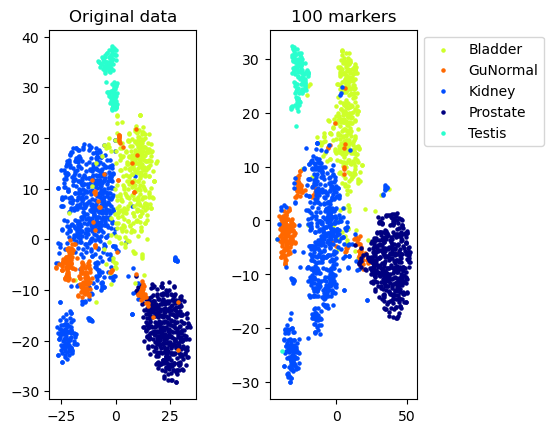

In [13]:
#one_vs_all_Markers = run_oneVSall(X_train,y_train)
one_vs_all_Markers = run_oneVSall(X_train,y_train_modified)

# ML

In [14]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2735,2736,2737,2738,2739,2740,2741,2742,2743,Target_encoded
Kidney_Tumor_79be9fd6-3e8f-404d-83a1-3d4289007a9e.methylation_array.sesame.level3betas.txt_WGBS,0.041398,0.022321,0.034114,0.026419,0.020082,0.020723,0.032999,0.037339,0.019733,0.023154,...,0.039203,0.047954,0.054096,0.063406,0.033352,0.053122,0.098124,0.065411,0.037977,4
Bladder_TCGA-BLCA_Primary_Tumor_4a810b58-b232-4f41-a768-6572b5e922d7.methylation_array.sesame.level3betas.txt_WGBS,0.033764,0.022424,0.024877,0.03004,0.021028,0.015158,0.031466,0.040935,0.016718,0.024245,...,0.040762,0.050192,0.056953,0.040163,0.030338,0.062638,0.068972,0.065411,0.042769,3
Kidney_Tumor_b2051e3a-eaa0-4fc3-936f-5ed5a9572ea2.methylation_array.sesame.level3betas.txt_WGBS,0.033403,0.0362,0.033911,0.029575,0.020697,0.016845,0.027595,0.029689,0.019049,0.021353,...,0.031493,0.042337,0.04099,0.05267,0.033583,0.041448,0.091488,0.065411,0.029608,4
Kidney_Tumor_37ae1055-91aa-4fbe-98ca-17312446bb2b.methylation_array.sesame.level3betas.txt_WGBS,0.048011,0.023716,0.036234,0.038815,0.02586,0.020146,0.03508,0.049515,0.023233,0.024823,...,0.043053,0.048937,0.062335,0.057973,0.029341,0.066259,0.071302,0.065411,0.04519,4
Prostate_gland_TCGA-PRAD_Primary_Tumor_6bb75e65-8f45-4e07-a2e2-282987b608ad.methylation_array.sesame.level3betas.txt_WGBS,0.045051,0.022253,0.031812,0.035832,0.024413,0.020334,0.038325,0.042437,0.020096,0.026303,...,0.039754,0.067428,0.104712,0.04617,0.043732,0.052287,0.059597,0.067473,0.040587,1


In [15]:
X_train_ready = X_train.drop(['Target_encoded'], axis = 1)
X_test_ready = X_test.drop(['Target_encoded'], axis = 1)
X_train_ready.head()
X_test_ready.head()

,0,1,2,3,4,5,6,7,8,9,...,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743
Kidney_Tumor_b5f41af9-03ab-4388-997d-e2d631ec9241.methylation_array.sesame.level3betas.txt_WGBS,0.032498,0.018238,0.02088,0.030308,0.01787,0.018518,0.029695,0.038562,0.01894,0.017064,...,0.028381,0.034118,0.042614,0.05857,0.040965,0.019048,0.040298,0.048062,0.065411,0.036273
Kidney_Tumor_6df298fa-7f9c-41a9-9686-81b95b5d58de.methylation_array.sesame.level3betas.txt_WGBS,0.047725,0.018465,0.029523,0.037044,0.022824,0.018273,0.0332,0.039838,0.020182,0.027174,...,0.030594,0.038268,0.065311,0.077037,0.049599,0.040847,0.050071,0.08168,0.07961,0.048592
Kidney_Tumor_65b24581-c15a-40cc-ae13-30d87567592a.methylation_array.sesame.level3betas.txt_WGBS,0.045623,0.021761,0.036585,0.032955,0.025447,0.016738,0.032633,0.04107,0.018877,0.026239,...,0.036467,0.039413,0.049255,0.066971,0.04716,0.034048,0.046196,0.060275,0.065411,0.039942
Bladder_TCGA-BLCA_Primary_Tumor_590fac5f-9ef0-4f63-826e-a9338bec441f.methylation_array.sesame.level3betas.txt_WGBS,0.042448,0.019978,0.026127,0.030391,0.020476,0.015693,0.029115,0.038846,0.015981,0.025598,...,0.021024,0.032436,0.040991,0.069125,0.053906,0.030414,0.064381,0.058469,0.065411,0.036692
Kidney_Tumor_9424d4c5-8aee-43e8-90d4-5b9e5c407a8b.methylation_array.sesame.level3betas.txt_WGBS,0.0446,0.02673,0.039261,0.030271,0.01959,0.019955,0.030315,0.039055,0.020434,0.03077,...,0.031551,0.042101,0.065559,0.063635,0.066372,0.046602,0.054266,0.095265,0.065411,0.042077


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def develop_random_forest_and_show_roc(X_train, y_train, X_test, y_test, feature_indices=None,title = 'Receiver Operating Characteristic to Multi-class'):
    # Select features based on indices if provided
    if feature_indices is not None:
        X_train = X_train.iloc[:, feature_indices]
        X_test = X_test.iloc[:, feature_indices]

    # Print the number of features used
    num_features = X_train.shape[1]
    print(f'Number of features used: {num_features}')

    # Determine the number of classes and unique labels
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    # Binarize the output for multiclass ROC
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Initialize and fit the RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Predict probabilities for each class
    y_score = clf.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    auc_scores = []
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores.append(roc_auc[i])

    # Calculate and print the average AUC
    avg_auc = np.mean(auc_scores)
    print(f'Average AUC: {avg_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'lightblue', 'lightgreen', 'gray', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0}.{1} (AUC = {2:0.2f})'.format(i + 1, classes[i].split('_')[0], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
    plt.tight_layout()
    plt.show()

    return clf


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def develop_random_forest_and_show_roc_and_confusion_matrix(X_train, y_train, X_test, y_test, feature_indices=None, title='Receiver Operating Characteristic to Multi-class'):
    # Select features based on indices if provided
    if feature_indices is not None:
        X_train = X_train.iloc[:, feature_indices]
        X_test = X_test.iloc[:, feature_indices]

    # Print the number of features used
    num_features = X_train.shape[1]
    print(f'Number of features used: {num_features}')

    # Determine the number of classes and unique labels
    classes = np.unique(y_train)
    n_classes = len(classes)

    # Print total samples and sample counts per class in training and testing
    print(f'Total training samples: {len(y_train)}')
    print("Training samples per class:", dict(zip(*np.unique(y_train, return_counts=True))))
    print(f'Total testing samples: {len(y_test)}')
    print("Testing samples per class:", dict(zip(*np.unique(y_test, return_counts=True))))
    
    # Format class labels for display
    display_labels = [cls.split('_')[0] for cls in classes]

    # Binarize the output for multiclass ROC
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Initialize and fit the RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Predict probabilities and labels for each class
    y_score = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    # Compute the confusion matrix and normalized confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the confusion matrix with actual counts
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp1.plot(ax=axes[0], cmap="Blues", values_format='d')
    axes[0].set_title('Confusion Matrix (Actual Counts)')
    
    # Plot the normalized confusion matrix
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=display_labels)
    disp2.plot(ax=axes[1], cmap="Blues", values_format='.2f')
    axes[1].set_title('Confusion Matrix (Normalized)')
    
    plt.tight_layout()
    plt.show()

    # Compute ROC curve and ROC area for each class
    auc_scores = []
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores.append(roc_auc[i])

    # Calculate and print the average AUC
    avg_auc = np.mean(auc_scores)
    print(f'Average AUC: {avg_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'lightblue', 'lightgreen', 'gray', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0}.{1} (AUC = {2:0.2f})'.format(i + 1, classes[i].split('_')[0], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
    plt.tight_layout()
    plt.show()

    return clf

# Example usage:
# Select features by index, e.g., using the first, third, and fifth features
# feature_indices = [0, 2, 4]
#clf = develop_random_forest_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,title = 'All Features')


In [17]:
print(X_train_ready.shape)
print(X_test_ready.shape)

(1728, 2744)
(432, 2744)


Number of features used: 2744
Total training samples: 1728
Training samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 334, 'GuNormal_Normal': 221, 'Kidney_Tumor': 651, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 402, 'Testis_TCGA-TGCT_Primary_Tumor': 120}
Total testing samples: 432
Testing samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 84, 'GuNormal_Normal': 55, 'Kidney_Tumor': 163, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 100, 'Testis_TCGA-TGCT_Primary_Tumor': 30}


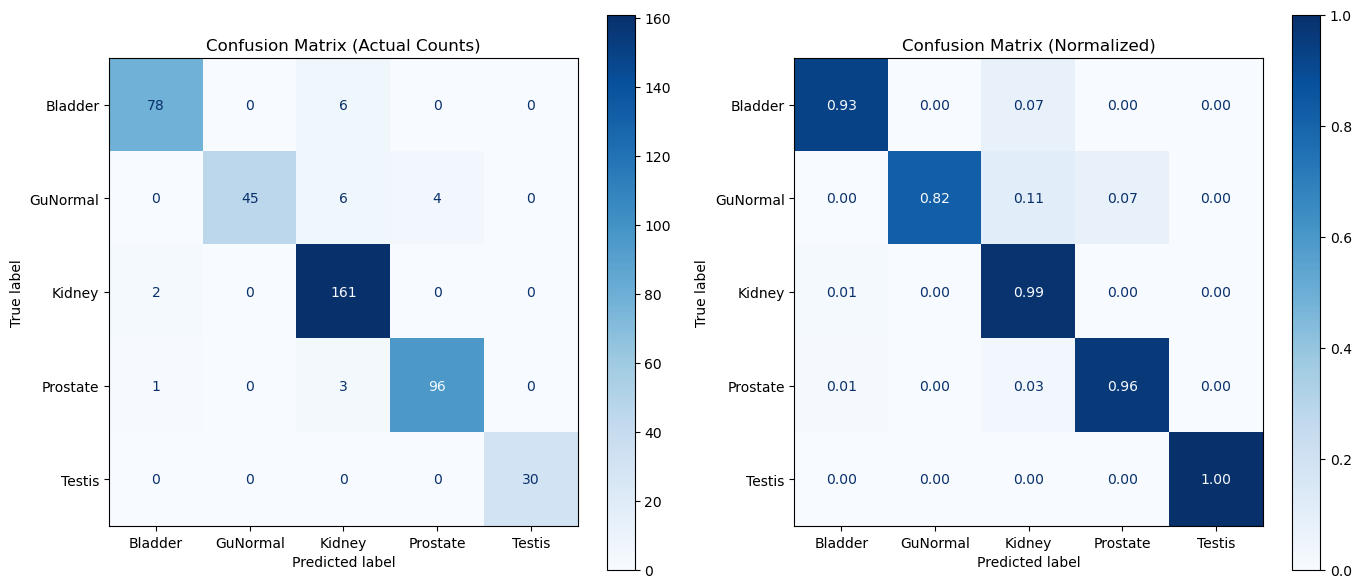

Average AUC: 0.99


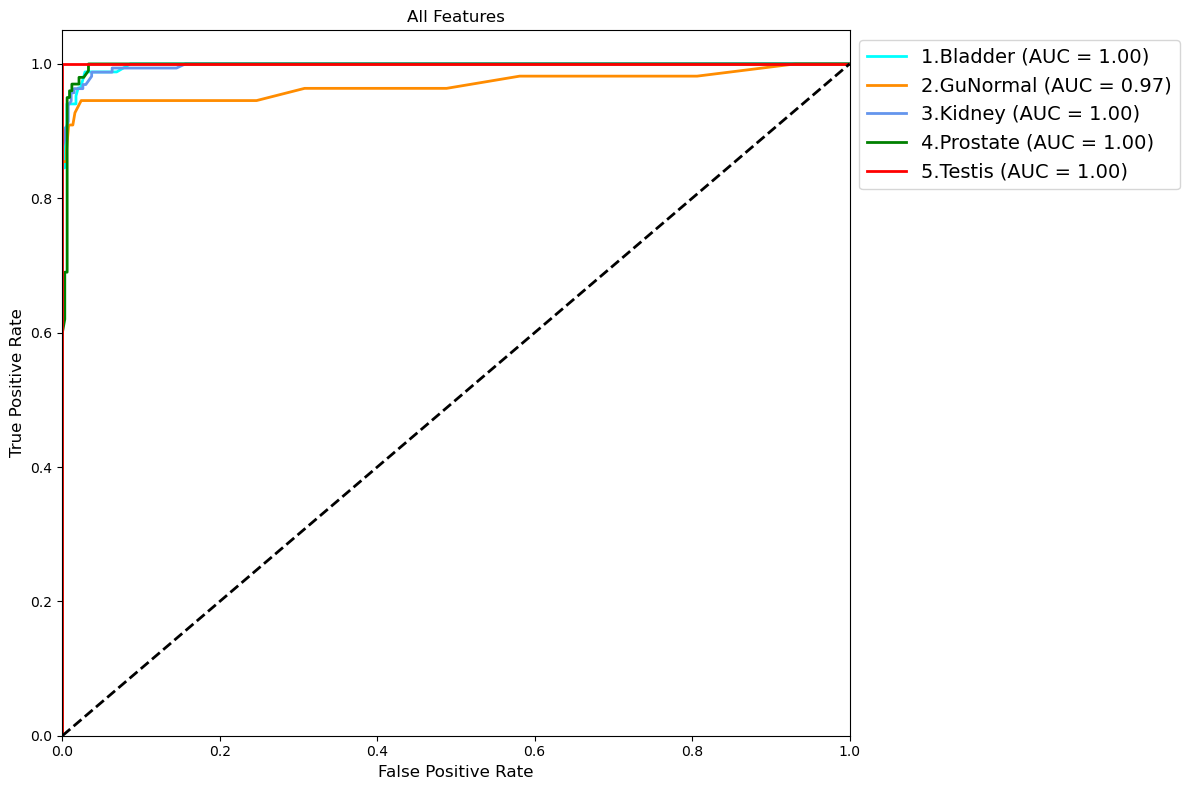

Number of features used: 100
Total training samples: 1728
Training samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 334, 'GuNormal_Normal': 221, 'Kidney_Tumor': 651, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 402, 'Testis_TCGA-TGCT_Primary_Tumor': 120}
Total testing samples: 432
Testing samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 84, 'GuNormal_Normal': 55, 'Kidney_Tumor': 163, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 100, 'Testis_TCGA-TGCT_Primary_Tumor': 30}


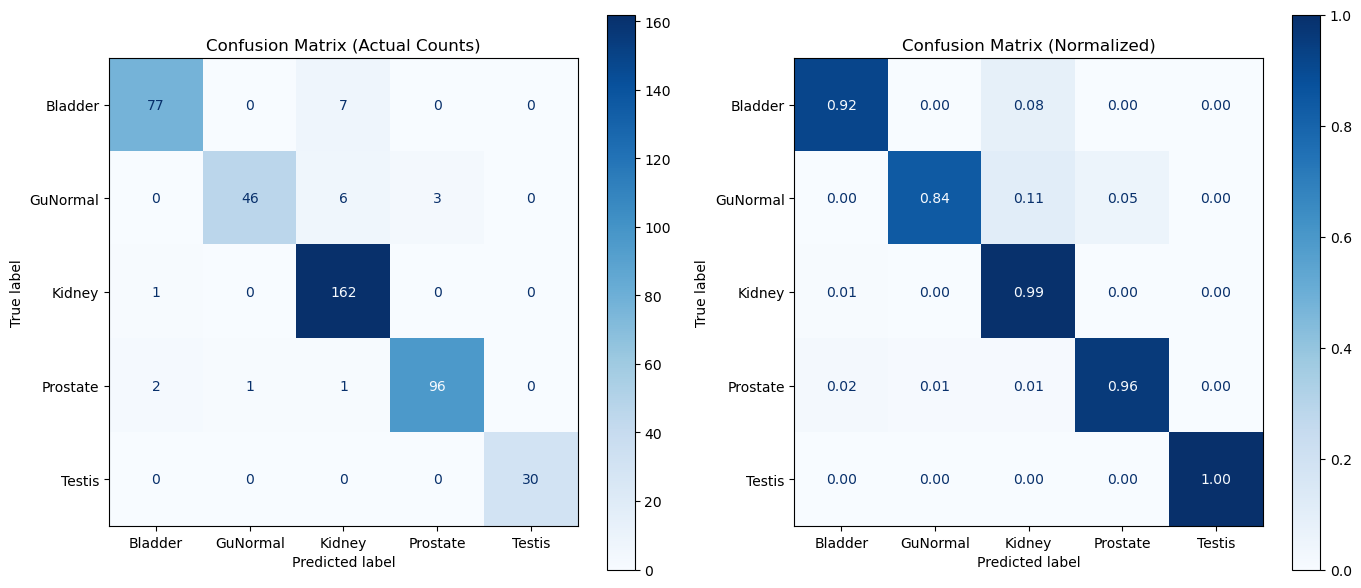

Average AUC: 0.99


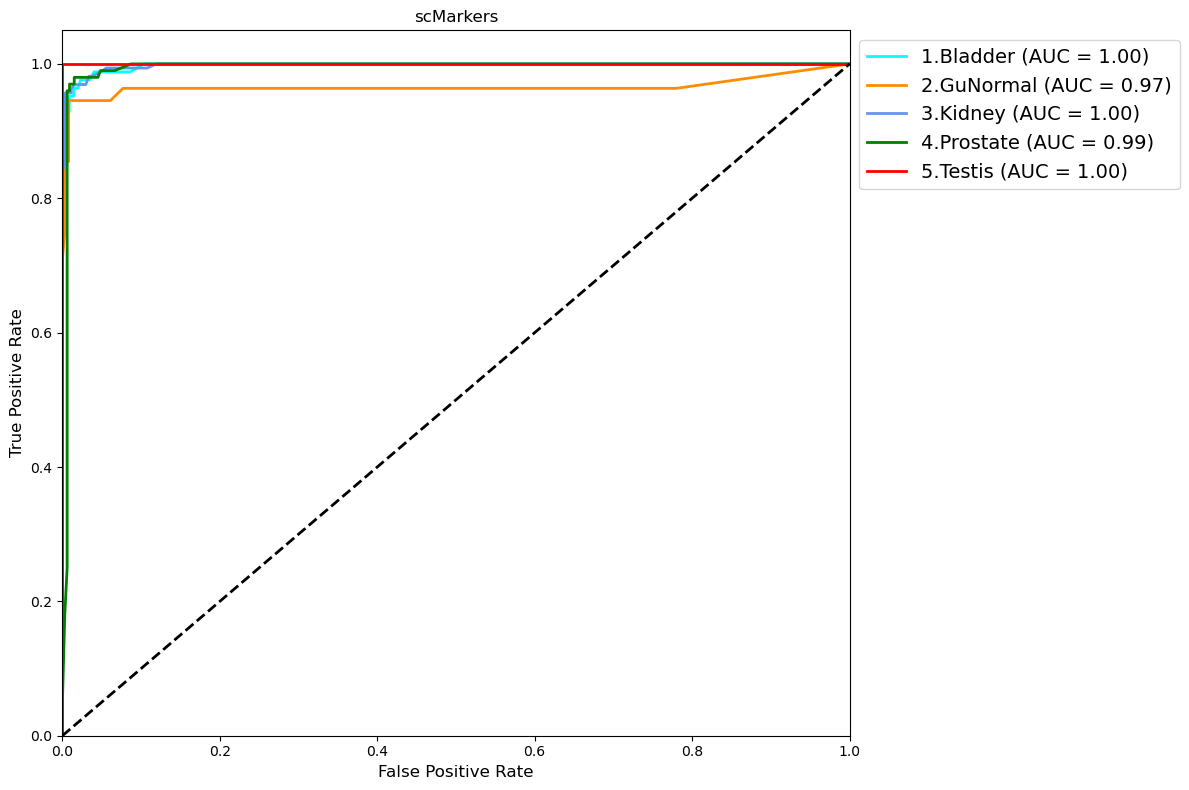

Number of features used: 100
Total training samples: 1728
Training samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 334, 'GuNormal_Normal': 221, 'Kidney_Tumor': 651, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 402, 'Testis_TCGA-TGCT_Primary_Tumor': 120}
Total testing samples: 432
Testing samples per class: {'Bladder_TCGA-BLCA_Primary_Tumor': 84, 'GuNormal_Normal': 55, 'Kidney_Tumor': 163, 'Prostate_gland_TCGA-PRAD_Primary_Tumor': 100, 'Testis_TCGA-TGCT_Primary_Tumor': 30}


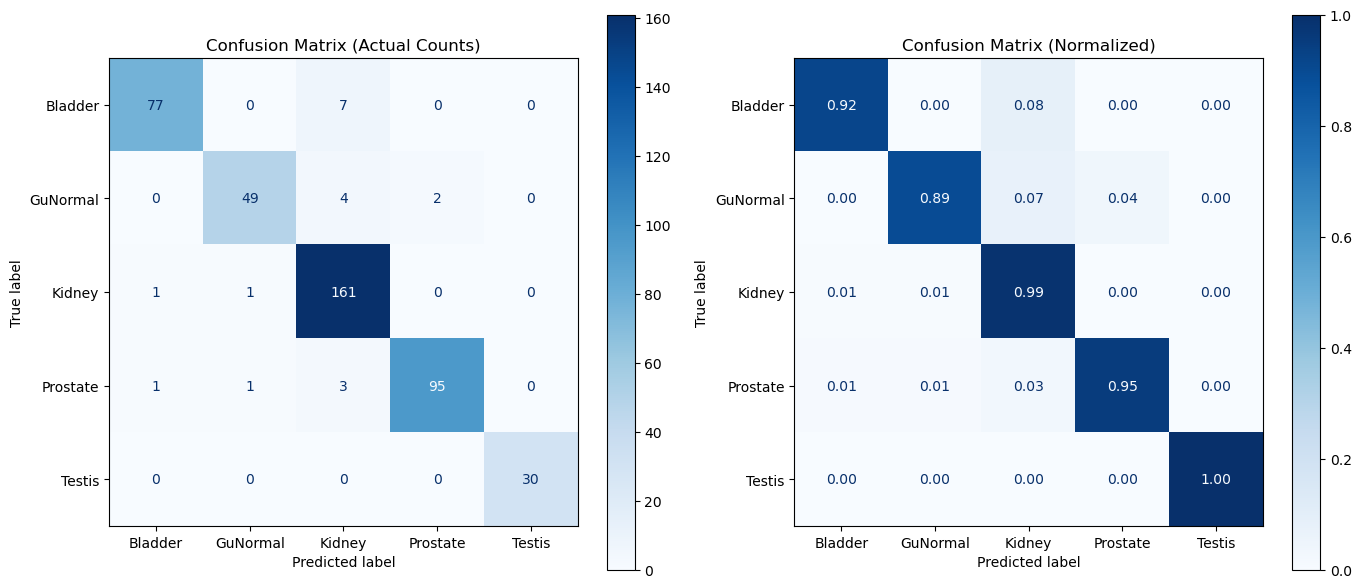

Average AUC: 0.99


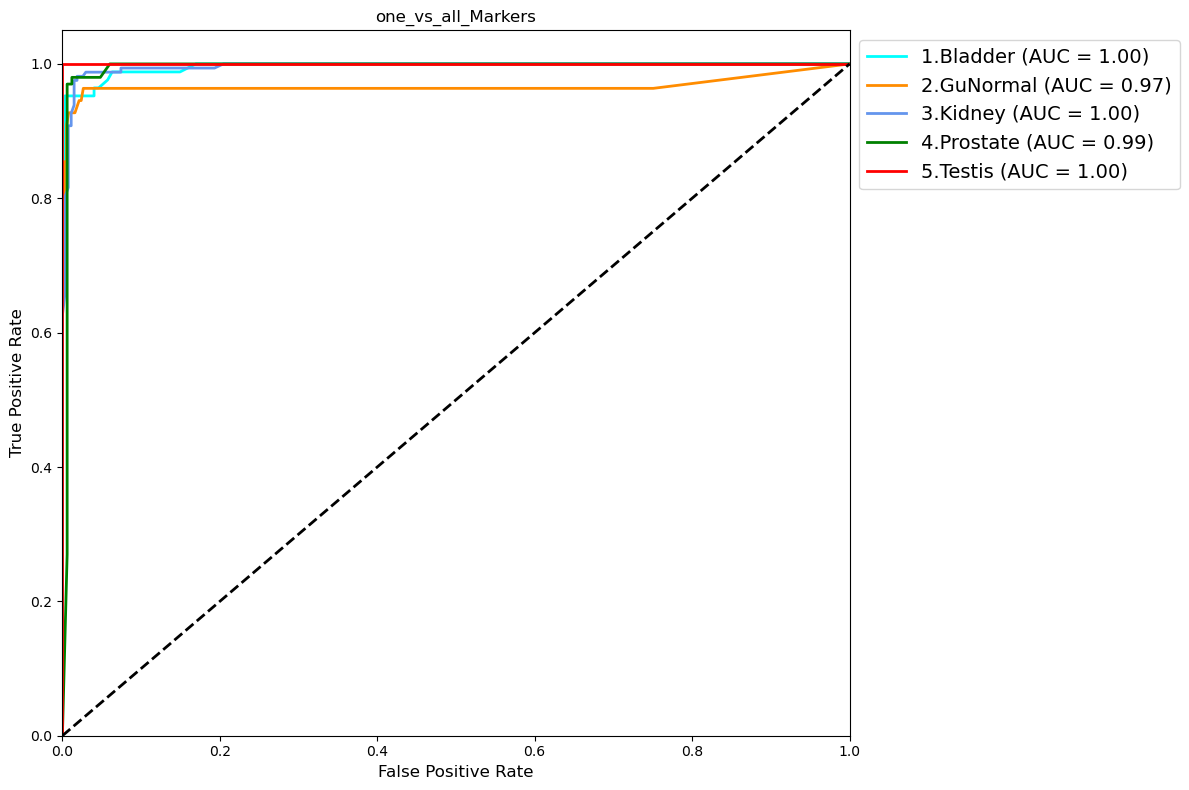

In [18]:
clf1 = develop_random_forest_and_show_roc_and_confusion_matrix(X_train_ready, y_train, X_test_ready, y_test,title = 'All Features')
clf2 = develop_random_forest_and_show_roc_and_confusion_matrix(X_train_ready, y_train, X_test_ready, y_test,feature_indices=scMarkers,title = 'scMarkers')
clf3 = develop_random_forest_and_show_roc_and_confusion_matrix(X_train_ready, y_train, X_test_ready, y_test,feature_indices=one_vs_all_Markers,title = 'one_vs_all_Markers')